### libraries and funcitions

In [1]:
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform
from copy import deepcopy
import matplotlib.pyplot as plt
import math

### structure of the individual

In [42]:
class Individual:
    """ Clase que implementa el individuo y sus operadores. El cromosoma de un individuo es una lista de caracteres,
       cada elemento de la lista es un gen cuyos alelos (caracteres) posibles se indican en allele_pool"""

    def __init__(self, chromosome, allele_pool):  # el constructor recibe el cromosoma  y el pool de alelos posibles
        
        self.chromosome = chromosome[:]
        self.allele_pool = allele_pool
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
        
    def print_chromosome(self):
        print('chromosome {}'.format(self.chromosome))
        print('fitness {}'.format(self.fitness))

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.chromosome))
        
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:], allele_pool)
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:], allele_pool)

        return [ind1, ind2]   
    
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1, allele_pool)
        ind2 = Individual(chromosome2, allele_pool)
        return [ind1, ind2] 

    def mutate_position(self):
        "Cambia aleatoriamente el alelo de un gen."
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = randrange(0,len(mutated_chromosome)) 
        newAllele1 = allele_pool[randrange(0,len(allele_pool))]
        newAllele2 = allele_pool[randrange(0,len(allele_pool))]
        mutated_chromosome[mutGene] = tuple([newAllele1, newAllele2])
        return Individual(mutated_chromosome, allele_pool)
        
    def mutate_swap(self):
        "Escoge dos genes e intercambia sus alelos"
        mutated_chromosome = deepcopy(self.chromosome)
        mutGen1 = randrange(0,len(mutated_chromosome))
        mutGen2 = randrange(0,len(mutated_chromosome))
        temp = mutated_chromosome[mutGen1]
        mutated_chromosome[mutGen1] = mutated_chromosome[mutGen2]
        mutated_chromosome[mutGen2] = temp
        return Individual(mutated_chromosome, allele_pool)

#### fitness function to evaluarte one individual

In [3]:
def matching_characters(chromosome, target_string):
    """Retorna el fitness de un cromosoma como el numero de caracteres coincidentes con la frase objetivo"""
    fitness = 0 # initialize fitness to 0
    for i in range(len(chromosome)):
        # increment fitness by 1 for every matching character
        if chromosome[i] == target_string[i]:
            fitness += 1
    return fitness

#### fitness evaluation for gpa maximization

In [4]:
def gpa_maximization(chromosome, queued_vehicles):
    """Retorna el fitness de un cromosoma la maximization de la funcion convexa"""
    fitness = 0 # initialize fitness to 0
    for i in range(len(chromosome)):
        # increment fitness by 1 for every matching character
        fitness += gpa_one_intersection(chromosome[i], queued_vehicles[i])
    return fitness

In [5]:
def gpa_one_intersection(time_inter, queued_inter, k=2):

    fitness = 0
    total_time = sum(time_inter) + 6

    for i in range(0, len(queued_inter)):
        fitness += gpa_one_lane(time_inter[i%2],queued_inter[i], total_time)
        
    return fitness

In [6]:
def gpa_one_lane(time_lane, queued_lane, total_time, k=2):
    v = time_lane/total_time
    w = 6/total_time

    fitness = queued_lane*math.log(v) + k*math.log(w)
    
    return fitness

#### fitness function to evaluarte one population


In [7]:
def evaluate_population(population, fitness_fn, queued_vehicles):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome, queued_vehicles)

#### fitness function to initialize one population

In [8]:
def init_population(pop_number, chromosome_size, allele_pool):
    """Initializes population for genetic algorithm
    pop_number  :  Number of individuals in population
    chromosome_size: The number of genes in each individual chromosome. 
    allele_pool :  List of possible values for the genes. This list is valid for all genes """
    num_alleles = len(allele_pool)
    population = []
    for i in range(pop_number):
        new_chromosome = [allele_pool[randrange(0, num_alleles)] for j in range(chromosome_size)]
        chromosome1 = new_chromosome[:10]
        chromosome2 = new_chromosome[10:]
        new_chromosome = list(zip(chromosome1, chromosome2))
        population.append( Individual(new_chromosome, allele_pool) )
    return population

#### selection parents function with the roulette method

In [9]:
def select_parents_roulette(population):
    popsize = len(population)

    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness < pickfitness: 
            iParent1 = i
            break
     

    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness < pickfitness: 
            iParent2 = i
            break

    return (population[iParent1], population[iParent2])

#### function that selects survivors for the next generation

In [10]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

### Genetic Algorithm

In [11]:
def genetic_algorithm(population, fitness_fn, queued_vehicles, ngen=1000, pmut=0.1, crossover="onepoint", mutation="position", selection_method="roulette"):
    
    popsize = len(population)
    evaluate_population(population, fitness_fn, queued_vehicles)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # mejor fitness

    #print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona las parejas de padres para cruzamiento 
        mating_pool = []
        if selection_method == 'tournament':
            for i in range(int(popsize/2)): 
                mating_pool.append(select_parents_tournament(population)) 
        
        if selection_method == 'roulette':
            for i in range(int(popsize/2)): 

                mating_pool.append(select_parents_roulette(population)) 
        
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 

            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut: 
                if mutation == "position":
                    offspring_population[i] = offspring_population[i].mutate_position()   # mutacion de una posicion
                elif mutation == "swap":
                    offspring_population[i] = offspring_population[i].mutate_swap()      # mutacion swap
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn, queued_vehicles)  # evalua la poblacion descendencia
        
        ## Selecciona popsize individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, popsize)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
        if (g % 10 == 0):
            best_string = population[ibest[0]].chromosome # convert the chromosome to a string for printing
            #print("generacion {}, Mejor individuol = {} (fitness = {})".format(g, best_string, population[ibest[0]].fitness))
        
    best_string = population[ibest[0]].chromosome
    #print("Mejor individuo en la ultima generacion ({}) = {} (fitness = {})".format(g, best_string, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la evolucion del mejor fitness x gen

#### testing genetic algorithm for the Generalized Proportional Allocation for traffic siganls

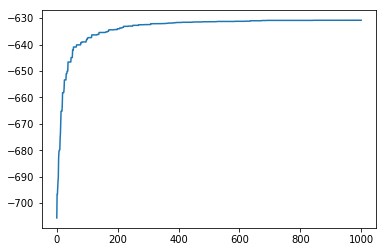

In [52]:
# build the pool of alleles with the suitable random numbers
target_example = [[10,20], [10,20], [10,20], [10,20], [10,20], [10,20], [10,20], [10,20], [10,20], [10,20]]
queued_vehicles = [[10,20,10,20], [10,20,10,20], [10,20,10,20], [10,20,10,20],[10,20,10,20], [10,20,10,20],
                   [10,20,10,20], [10,20,10,20],[10,20,10,20], [10,20,10,20]]
allele_pool = []
allele_pool.extend( [x for x in range(20, 180)]) # posibles valores para los semaforos en verde

#initialize a initial population randomnly
num_individuals = 100
population = init_population(num_individuals, len(target_example)*2, allele_pool)

#call genetic algorithm
best_ind, best_fitness = genetic_algorithm(population, gpa_maximization, queued_vehicles, 1000, 0.9, "onepoint", "position")

plt.plot(best_fitness)
plt.show()


In [50]:
best_ind.print_chromosome()

chromosome [(20, 36), (20, 37), (20, 35), (20, 37), (20, 37), (20, 37), (20, 36), (20, 37), (20, 38), (20, 38)]
fitness -630.5304803478905


In [25]:
best_ind.print_chromosome()

chromosome [(28, 67), (23, 29), (27, 45), (38, 44), (38, 89), (29, 75), (28, 70), (21, 41), (27, 37), (24, 50)]
fitness -645.8183051848637


In [29]:
best_ind.print_chromosome()

chromosome [(30, 74), (43, 88), (27, 36), (53, 70), (43, 56), (28, 35), (28, 45), (28, 69), (24, 54), (20, 48)]
fitness -648.8763198203349
